# Transfer Learning with MobileNetV2



- [1 - Import Packages](#1)

- [2 - Preprocess the Training Data](#2)

- [3 - Using MobileNetV2 for Transfer Learning](#3)


<a name='1'></a>
## 1 - Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

<a name='1-1'></a>
### Loading the Dataset, and Splitting it into Training and Validation Sets

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Therefor, we call `image_data_set_from_directory()` to read from the directory.


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


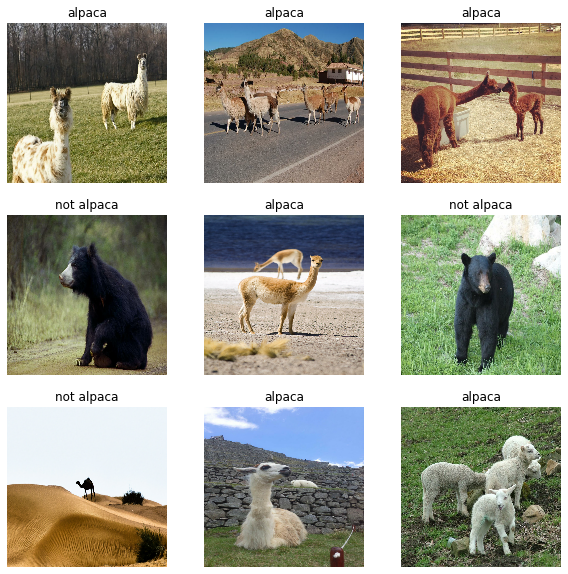

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='2'></a>
## 2 - Preprocess the Training Data


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

Take a look at how an image from the training set has been augmented with simple transformations:

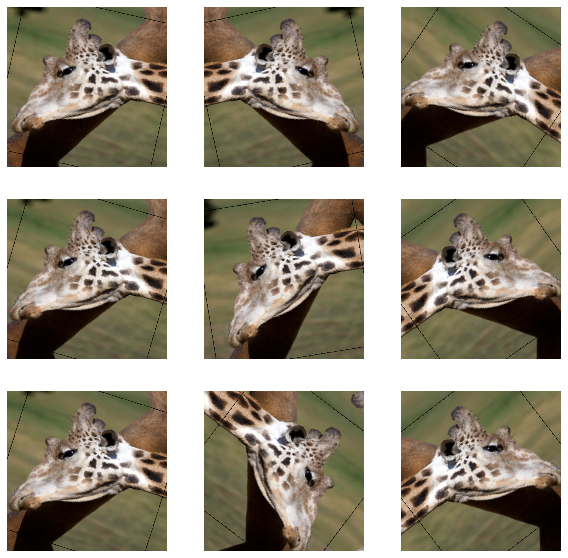

In [7]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a name='3'></a>
## 3 - Using MobileNetV2 for Transfer Learning 

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks. The architecture has three defining characteristics:

*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers



In [9]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14540800/14536120 [==============================] - 0s 0us/step


In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

In [11]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [13]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

In [14]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

40960/35363 [==================================] - 0s 0us/step


[[('n04589890', 'window_screen', 0.42582113),
  ('n02708093', 'analog_clock', 0.09275588)],
 [('n04589890', 'window_screen', 0.23985851),
  ('n03887697', 'paper_towel', 0.14802593)],
 [('n04589890', 'window_screen', 0.7449468),
  ('n03598930', 'jigsaw_puzzle', 0.021948555)],
 [('n04589890', 'window_screen', 0.3354602),
  ('n03530642', 'honeycomb', 0.0762895)],
 [('n04589890', 'window_screen', 0.27327338),
  ('n03733281', 'maze', 0.08846959)],
 [('n04589890', 'window_screen', 0.6745217),
  ('n03530642', 'honeycomb', 0.076599255)],
 [('n04589890', 'window_screen', 0.79128474),
  ('n04209239', 'shower_curtain', 0.0924166)],
 [('n04589890', 'window_screen', 0.1646301),
  ('n03598930', 'jigsaw_puzzle', 0.08749153)],
 [('n03598930', 'jigsaw_puzzle', 0.37021384),
  ('n04589890', 'window_screen', 0.099569514)],
 [('n04589890', 'window_screen', 0.6161648),
  ('n03887697', 'paper_towel', 0.054877095)],
 [('n03530642', 'honeycomb', 0.254489),
  ('n04589890', 'window_screen', 0.24874294)],
 [('n04

Uh-oh. There's a whole lot of labels here, some of them hilariously wrong, but none of them say "alpaca."

This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when we use the full model, all we get is a bunch of incorrectly classified images.

Fortunately, you can delete the top layer, which contains all the classification labels, and create a new classification layer.


Layer Freezing with the Functional API

We now use a pretrained model to modify the classifier task so that it's able to recognize alpacas in three steps: 

1. Delete the top layer (the classification layer)
   
2. Add a new classifier layer
    
3. Freeze the base model and train the newly-created classifier layer
   


###  alpaca_model

In [17]:

def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False
    
    # create the input layer 
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    x = tfl.GlobalAveragePooling2D()(x) 
    x = tfl.Dropout(0.2)(x)
        
    # create a prediction layer with one neuron 
    prediction_layer = tfl.Dense(1)
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [18]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [20]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 8s 933ms/step - loss: 0.7568 - accuracy: 0.5420 - val_loss: 0.6415 - val_accuracy: 0.5538
Epoch 2/5
9/9 [==============================] - 7s 811ms/step - loss: 0.5549 - accuracy: 0.6679 - val_loss: 0.5062 - val_accuracy: 0.6308
Epoch 3/5
9/9 [==============================] - 7s 800ms/step - loss: 0.5744 - accuracy: 0.6908 - val_loss: 0.4224 - val_accuracy: 0.7077
Epoch 4/5
9/9 [==============================] - 7s 800ms/step - loss: 0.4859 - accuracy: 0.7290 - val_loss: 0.4244 - val_accuracy: 0.6769
Epoch 5/5
9/9 [==============================] - 7s 800ms/step - loss: 0.4599 - accuracy: 0.7557 - val_loss: 0.3303 - val_accuracy: 0.7077


Plot the training and validation accuracy:

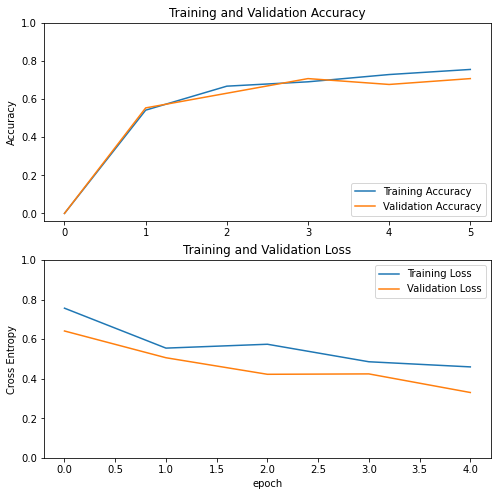

In [22]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
class_names

['alpaca', 'not alpaca']

The results are ok, but could be better. Next, try some fine-tuning.


### Fine-tuning the Model


In [24]:

base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 126

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = None
    
# Define a BinaryCrossentropy loss function.
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  157


In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 8s 877ms/step - loss: 0.4124 - accuracy: 0.7672 - val_loss: 0.3279 - val_accuracy: 0.7077
Epoch 6/10
9/9 [==============================] - 7s 812ms/step - loss: 0.4451 - accuracy: 0.7595 - val_loss: 0.3305 - val_accuracy: 0.7077
Epoch 7/10
7/9 [======================>.......] - ETA: 1s - loss: 0.4321 - accuracy: 0.7679

Quite an improvement! A little fine-tuning can really go a long way.